(examples)=

# Examples

In [1]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 12
rcParams["legend.frameon"] = False
rcParams["lines.markersize"] = 10

import warnings
warnings.filterwarnings('ignore')

We collected some more in-depth examples below that demonstrate all features of riccati.

## Quick summary of the algorithm

The riccati solver solves ODEs whose solution may vary between oscillatory and slowly varying inside the solution interval. It does this by automatically switching between two methods: in oscillatory regions, an asymptotic series is computed to approximate the solution; in regions of few to no oscillations, a Chebyshev-grid-based collocation method is used. For more details, see our [paper](https://arxiv.org/abs/2212.06924).

In the examples below, we'll refer to the two types of steps as **Riccati** and **Chebyshev**.

## Optional and tuning parameters

In this section, we'll go through each optional (keyword-) parameter the riccati solver accepts.

### Tolerances

There are two tolerances the user can set. 

The first, `eps`, controls the relative local error. In both Riccati and Chebyshev steps, the step is accepted only if its estimated error is less than or equal to `eps`. 

The other, `epsh`, only affects Riccati steps. It is not used within the step, rather, to determine what size of step is possible with an asymptotic approximation. For small values of `eps`, small values of `epsh` are necessary, otherwise too large stepsizes may be chosen for Riccati steps to reach an error (residual) of `eps`.

We show a low, an intermediate, and a large tolerance example below on the equation 

$$ u'' + \frac{m^2 - 1}{(1 + t^2)^2} = 0, $$

with $m = 1000$, solved on $t \in [-m, m]$ and subject to initial conditions $u(-m) = \tilde{u}(-m)$, $u'(-m) = \tilde{u}'(-m)$, where $\tilde{u}$ is the analytic solution:

$$ \tilde{u}(t) = \frac{\sqrt{1 + t^2}}{m} e^{i m \arctan(t)}.$$

In [2]:
import numpy as np
import riccati

# Set up the ODE
m = 1000
w = lambda t: np.sqrt(m**2 - 1)/(1 + t**2)
g = lambda t: np.zeros_like(t)

# Analytic solution
y_ana = lambda t: np.sqrt(1 + t**2)/m*(np.cos(m*np.arctan(t)) + 1j*np.sin(m*np.arctan(t)))
dy_ana = lambda t: 1/np.sqrt(1 + t**2)/m*((t + 1j*m)*np.cos(m*np.arctan(t))\
                                          + (-m + 1j*t)*np.sin(m*np.arctan(t)))
                                

# Specify integration range and i.c.
ti = -m
tf = m
yi = y_ana(ti)
dyi = dy_ana(ti)

# Set up solver
info = riccati.solversetup(w, g)

In [3]:
# High tolerance
eps = 1e-4
epsh = 1e-5
ts_high, ys_high, *misc_high = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Intermediate tolerance
eps = 1e-8
epsh = 1e-12
ts_inter, ys_inter, *misc_inter = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Low tolerance
eps = 1e-12
epsh = 1e-13
ts_low, ys_low, *misc_low = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Compute numerical errors
y_ana_high = y_ana(np.array(ts_high))
y_ana_inter = y_ana(np.array(ts_inter))
y_ana_low = y_ana(np.array(ts_low))
err_high = np.abs((ys_high - y_ana_high)/y_ana_high)
err_inter = np.abs((ys_inter - y_ana_inter)/y_ana_inter)
err_low = np.abs((ys_low - y_ana_low)/y_ana_low)

Now let's compare the numerical error with the different tolerance settings:

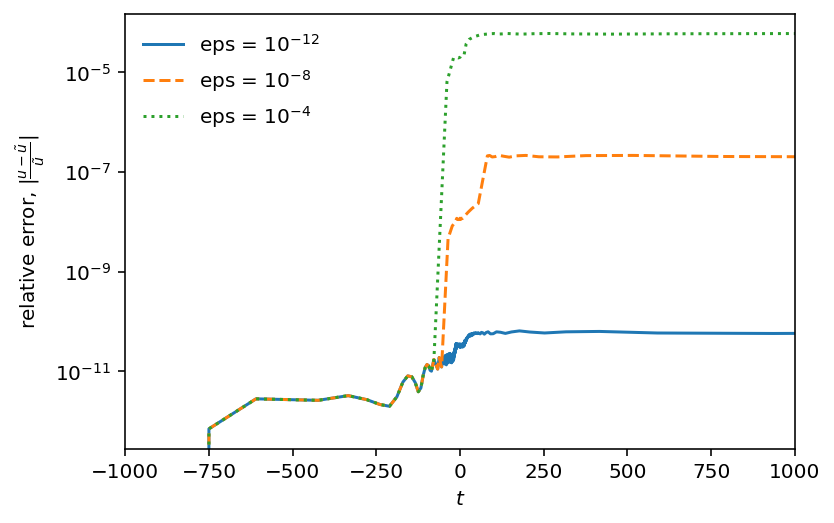

In [4]:
from matplotlib import pyplot as plt

plt.figure()
plt.semilogy(ts_low, err_low, label = "eps = $10^{-12}$")
plt.semilogy(ts_inter, err_inter, '--', label = "eps = $10^{-8}$")
plt.semilogy(ts_high, err_high, ls = 'dotted', label = "eps = $10^{-4}$")
plt.xlim(-m, m)
plt.xlabel('$t$')
plt.ylabel('relative error, $|\\frac{u - \\tilde{u}}{\\tilde{u}}|$')
plt.legend()
plt.show()

Let's see what happens in the extreme case of `epsh` > `eps`:

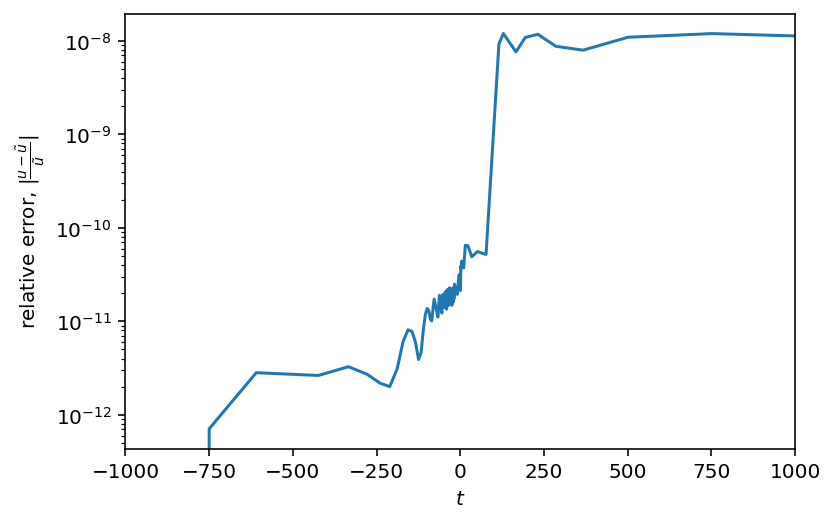

In [5]:
# Low eps, high epsh
eps = 1e-10
epsh = 1e-8
ts_weird, ys_weird, *misc_weird = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Calculate numerical error
y_ana_weird = y_ana(np.array(ts_weird))
err_weird = np.abs((ys_weird - y_ana_weird)/y_ana_weird)

# Plot
plt.figure()
plt.semilogy(ts_weird, err_weird)
plt.xlim(-m, m)
plt.xlabel('$t$')
plt.ylabel('relative error, $|\\frac{u - \\tilde{u}}{\\tilde{u}}|$')
plt.show()

Uh-oh, we didn't get the required relative error because `epsh` was too large. As a rule of thumb, start with `epsh` = `eps`/10, then explore lower values to see if your solution has converged. Using the rule of thumb we get the desired error:

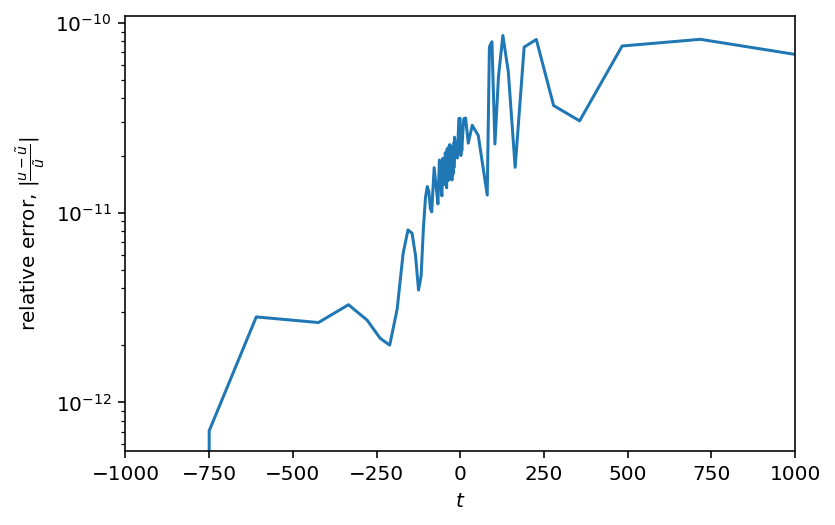

In [6]:
# Low eps, appropriate epsh
eps = 1e-10
epsh = 1e-11
ts_weird, ys_weird, *misc_weird = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Calculate numerical error
y_ana_weird = y_ana(np.array(ts_weird))
err_weird = np.abs((ys_weird - y_ana_weird)/y_ana_weird)

# Plot
plt.figure()
plt.semilogy(ts_weird, err_weird)
plt.xlim(-m, m)
plt.xlabel('$t$')
plt.ylabel('relative error, $|\\frac{u - \\tilde{u}}{\\tilde{u}}|$')
plt.show()

### Hard stopping

`hard_stop` is an optional boolean parameter given to `riccati.solve`. Setting it to True forces the solver to truncate its last stepsize to finish exactly at $t = t_f$, otherwise using an optimal stepsize which may cause it to exceed $t_f$. The solution value would then be available through interpolation (e.g. by asking for dense output to be produced at $t_f$). This is the preferred method, but if $t_f$ is not to be exceeded for any reason, e.g. because of a singularity in the ODE, the parameter should be set to True. 

`hard_stop = True` should otherwise be avoided because it may cause the last step to be too small -- computing a large number of collocation nodes over a short interval will result in loss of accuracy due to rounding error.

Let's see the different options for `hard_stop` in action:

In [7]:
# We'll solve the Airy equation, where w(t) = sqrt(t) and g(t) = 0:
w = lambda t: np.sqrt(t)
g = lambda t: np.zeros_like(t)

# The analytic solution is available through the SciPy package
import scipy.special as sp

# Initial conditions and tolerance
ti = 1.0
tf = 40.0
ui = sp.airy(-ti)[0] + 1j*sp.airy(-ti)[2]
dui = - sp.airy(-ti)[1] - 1j*sp.airy(-ti)[3]
eps = 1e-10
epsh = 1e-11

# Set up and solve
info = riccati.solversetup(w, g)
# Giving xeval = [tf] ensures that we get a solution estimate at tf
ts_nostop, ys_nostop, *misc_nostop, y_eval_nostop = riccati.solve(info, ti, tf, ui, dui, eps = eps,\
                                                   epsh = epsh, xeval = np.array([tf]))
ts_stop, ys_stop, *misc_stop = riccati.solve(info, ti, tf, ui, dui, eps = eps,\
                                             epsh = epsh, hard_stop = True)

# For visualization, generate the analytic solution at many points
ts_ana = np.linspace(ti, tf, 800)
ys_ana = np.array([sp.airy(-t)[0] + 1j*sp.airy(-t)[2] for t in ts_ana])

# Generate some more outside of the solution interval
ts_ana_ctd = np.linspace(tf, 105, 2000)
ys_ana_ctd = np.array([sp.airy(-t)[0] + 1j*sp.airy(-t)[2] for t in ts_ana_ctd])

Let's plot the natural steps of the solver...

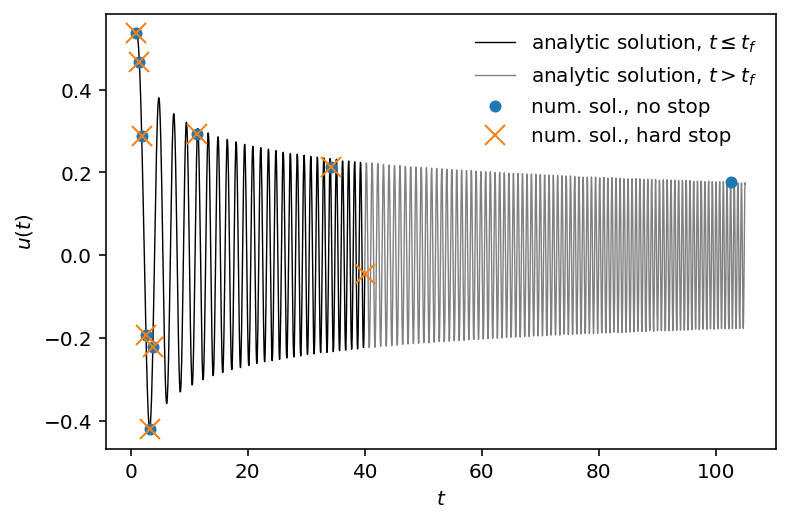

In [8]:
plt.figure()
plt.plot(ts_ana, ys_ana, color = 'k', lw = 0.7, label = 'analytic solution, $t \leq t_f$')
plt.plot(ts_ana_ctd, ys_ana_ctd, color = 'grey', lw = 0.7, label = 'analytic solution, $t > t_f$')
plt.plot(ts_nostop, ys_nostop, '.', label = 'num. sol., no stop')
plt.plot(ts_stop, ys_stop, 'x', label = 'num. sol., hard stop')
plt.xlabel('$t$')
plt.ylabel('$u(t)$')
plt.legend()
plt.show()

... and inspect the numerical error at $t = t_f$:

In [9]:
y_ana = ys_ana[-1]
y_stop = ys_stop[-1]
y_nostop = y_eval_nostop[-1]

# Hard stop:
y_err_stop = abs((y_nostop - y_ana)/y_ana)
# Interpolation:
y_err_nostop = abs((y_stop - y_ana)/y_ana)

print("Numerical error when forcing a stop at t = tf: {}\nNumerical error when stopping naturally and interpolating: {}".format(y_err_stop, y_err_nostop))

Numerical error when forcing a stop at t = tf: 7.739889543991207e-11
Numerical error when stopping naturally and interpolating: 8.277574203180603e-12


### Number of collocation points

The number of collocation points/nodes plays a role in both type of steps. There are a total of 4 parameters controlling the number of nodes, all optional arguments to `riccati.solversetup`. `n, p` are relevant for Riccati steps, whereas `nini, nmax` relate to Chebyshev steps. Below's a quick summary of what they are.

- `n` (default value: 16) is the number of Chebyshev nodes used for interpolation, integration, and differentiation in Riccati steps.
- `p` (default value: 16) is the number of Chebyshev nodes used when determining the Riccati step size. It doesn't need to be equal to `n`.
- `nini` (default value: 16) is the starting number of nodes a Chebyshev step will be attempted with, to be doubled in every iteration (and error estimate).
- `nmax` (default value: 32) is the largest number of nodes a Chebyshev step will be attempted with. The default is `2*nini` as that will mean attempting a Chebyshev step with `2*nini` nodes, estimating its error with the result of the step with `nini` nodes.

Let's see how much the number of nodes affects the efficiency an accuracy on the example of the Airy equation solved to extremely late times:

In [10]:
# We have to invoke a special package for accurate late-time Airy solutions
import mpmath

# Initial conditions and tolerance
ti = 1.0
tf = 1e8
ui = sp.airy(-ti)[0] + 1j*sp.airy(-ti)[2]
dui = - sp.airy(-ti)[1] - 1j*sp.airy(-ti)[3]
eps = 1e-12
epsh = 1e-13

# Try solving with the default numbe of (Riccati) collocation points
info_def = riccati.solversetup(w, g)
ts_def, ys_def, *misc, = riccati.solve(info_def, ti, tf, ui, dui, eps = eps, epsh = epsh)

# Try a smaller number of collocation points
info_n10 = riccati.solversetup(w, g, n = 10, p = 10)
ts_n10, ys_n10, *misc, = riccati.solve(info_n10, ti, tf, ui, dui, eps = eps, epsh = epsh)

# Compute numerical errors
ys_ana_def = np.array([mpmath.airyai(-t) + 1j*mpmath.airybi(-t) for t in ts_def])
ys_ana_n10 = np.array([mpmath.airyai(-t) + 1j*mpmath.airybi(-t) for t in ts_n10])
errs_def = np.abs((ys_ana_def - ys_def)/ys_ana_def)
errs_n10 = np.abs((ys_ana_n10 - ys_n10)/ys_ana_n10)

Plot the solver's error progression:

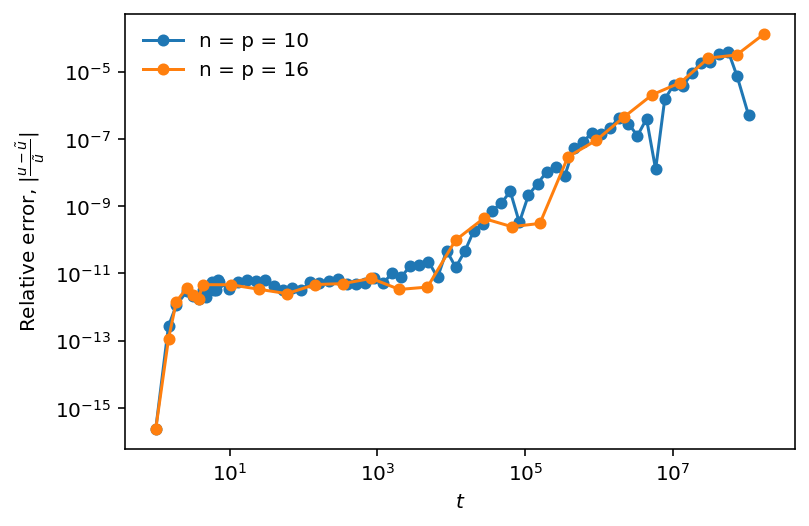

In [11]:
plt.figure()
plt.loglog(ts_n10, errs_n10, '.-', label = 'n = p = 10')
plt.loglog(ts_def, errs_def, '.-', label = 'n = p = 16')
plt.xlabel('$t$')
plt.ylabel('Relative error, $|\\frac{u - \\tilde{u}}{\\tilde{u}}|$')
plt.legend()
plt.show()

The stepsizes inside the highly oscillatory region grew, but the steps have gotten more computationally expensive -- in general it is a good idea to try multiple $n$-s (and $p$-s) to see when the solution and stepsizes converge.

### Initial interval length for estimating initial stepsizes

The algorithm chooses its stepsizes automatically at all times, by estimating the timescales over which the ODE coefficients and the solution vary. But in order to do this, it requires an estimate of $\omega'(t)$ and $\gamma'(t)$ around $t = t_i$. The width of the region which it will survey to estimate these derivatives around $t_i$ is this initial interval, passed as an optional keyword argument `h0` to `riccati.solversetup`.
Setting it to something **very** large or smaller than machine precision may result in an error:

In [12]:
# Solving the Airy equation again
# Way too large initial interval length
try:
    info_hlarge = riccati.solversetup(w, g, h0 = 1e6)
    riccati.solve(info_hlarge, ti, tf, ui, dui, eps = eps, epsh = epsh)
except RuntimeError as error_hlarge:
    print(error_hlarge)

Solution didn't converge between h = 1e-16


In [13]:
# Initial interval length less than hard-coded limit 1e-16
ti = 1e5
tf = 1e6
try:
    info_hsmall = riccati.solversetup(w, g, h0 = 1e-16)
    ts, ys, *misc = riccati.solve(info_hsmall, ti, tf, ui, dui, eps = eps, epsh = epsh, hard_stop = True)
except RuntimeError as error_hsmall:
    print(error_hsmall)

Solution didn't converge between h = 1e-16


## Solving an ODE one step at a time

For easier integration into other software, riccati includes some low-level utility functions for advancing the solution one step (or a few, unknown number of steps) at a time. These have some pitfalls, so we'll show how to use them below.

### Single step

The relevant functions are `riccati.nonosc_step` and `riccati.osc_step`. For They both rely on a `Solverinfo` object storing up-to-date information of the run. 

Let's say we have an ODE that behaves as stiff from time to time, so wish to sometimes switch between a stiff method and riccati's Chebyshev method on the fly. Individual steps can be taken without creating computational overhead by calling `riccati.solversetup` at each switch:

In [53]:
# Still using the Airy example.

# Integration range, with a switching point at t = tswitch = 2
ti = 1.0
tf = 1e5
tswitch = 10.0

# One setup of the solver is necessary at the very start, the resulting info object stores differentiation and integration matrices, Chebyshev nodes, etc.
info = riccati.solversetup(w, g)

# From t = ti to t = tswitch, we pretend to have used some alternative solver.
# It produced the solution uswitch, duswitch
ui = sp.airy(-tswitch)[0] + 1j*sp.airy(-tswitch)[2]
dui = - sp.airy(-tswitch)[1] - 1j*sp.airy(-tswitch)[3]
# We wish to take a single step of size h
h = 0.1

unext, dunext, maxerr, status, *misc = riccati.nonosc_step(info, tswitch, h, ui, dui)

# Was the step successful?
print("Was the step successful?", status == True)

# Check the numerical error
uana = sp.airy(-(tswitch + h))[0] + 1j*sp.airy(-(tswitch + h))[2]
print("Estimated numerical error:", maxerr)
#print(uana, unext)
print("Numerical error:", abs((uana - unext)/uana))

Was the step successful? True
Estimated numerical error: 5.01710591524615e-13
Numerical error: 4.408599131219293e-13


It is possible to get riccati to choose `h` above automatically, by calling `riccati.choose_nonosc_stepsize` with an initial guess `h0`:

In [54]:
# Crude initial guess
h0 = 1/w(tswitch)
h = riccati.choose_nonosc_stepsize(info, tswitch, h0)

# What's the refined stepsize?
print("More refined h:", h)

# Take a step, measure its error
unext, dunext, maxerr, status, *misc = riccati.nonosc_step(info, tswitch, h, ui, dui)
print("Was the step successful?", status == True)
uana = sp.airy(-(tswitch + h))[0] + 1j*sp.airy(-(tswitch + h))[2]
print("Estimated numerical error:", maxerr)
print("Numerical error:", abs((uana - unext)/uana))

More refined h: 0.31622776601683794
Was the step successful? True
Estimated numerical error: 1.1653297982176096e-13
Numerical error: 1.0611604824794764e-13


Riccati steps rely on two pre-computed arrays, `Solverinfo.wn`, and `Solverinfo.gn`, of $\omega$ and $\gamma$ evaluations at Chebyshev nodes spread over the upcoming step. These can be set by hand (requires a stepsize-estimate), or most easily by calling `riccati.choose_osc_stepsize` before calling the single Riccati step:

In [61]:
# Crude initial stepsize
h0 = 20.0

# We need to populate info.wn, info.gn ahead of the step
# An easy way to do it is to call the stepsize-chooser
h = riccati.choose_osc_stepsize(info, tswitch, h0)

# What's the refined stepsize?
print("More refined h:", h)

# Take a step, measure its error
unext, dunext, maxerr, status, *misc = riccati.osc_step(info, tswitch, h, ui, dui)
print("Was the step successful?", status == True)
uana = sp.airy(-(tswitch + h))[0] + 1j*sp.airy(-(tswitch + h))[2]
print("Estimated numerical error:", maxerr)
print("Numerical error:", abs((uana - unext)/uana))

More refined h: 14.0
Was the step successful? True
Estimated numerical error: 6.228311213018032e-13
Numerical error: 8.618691252868772e-14


The more manual way is shown below:

In [63]:
# One can also do it manually, the info object already contains the unscaled Chebyshev nodes xn
tn = info.xn
tn_scaled = tswitch + h/2 + h/2*tn
wn = w(tn_scaled)
gn = g(tn_scaled)

# Take a step, measure its error
unext, dunext, maxerr, status, *misc = riccati.osc_step(info, tswitch, h, ui, dui)
print("Was the step successful?", status == True)
uana = sp.airy(-(tswitch + h))[0] + 1j*sp.airy(-(tswitch + h))[2]
print("Estimated numerical error:", maxerr)
print("Numerical error:", abs((uana - unext)/uana))

Was the step successful? True
Estimated numerical error: 6.228311213018032e-13
Numerical error: 8.618691252868772e-14


### Several steps within an interval

The functions `riccati.osc_evolve`, `riccati.nonosc_evolve` provide a way to string together steps of a given kind (Chebyshev, Riccati) until some time is reached. 

In [ ]:
ti = 1e2
tf = 1e6
ui = sp.airy(-ti)[0] + 1j*sp.airy(-ti)[2]
dui = - sp.airy(-ti)[1] - 1j*sp.airy(-ti)[3]

